In [1]:
import os 
import pickle
import numpy as np
import pandas as pd
import nibabel as nib
import tensorflow as tf
from scipy import ndimage
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

2023-04-12 08:45:55.255461: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-12 08:45:55.399386: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-12 08:45:56.402132: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /software/spackages/linux-rocky8-x86_64/gcc-9.5.0/cudnn-8.1.0.77-11.2-o55zmcsaca6xrl5uyyaalmxt2nabqytf/lib64:/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/cuda-11.2.2-ud5pedf473of4in4vhulabsyve3snph4/

In [2]:
os.getcwd()

'/home/cbasire/Data Mining'

In [3]:
from glob import glob
import matplotlib.pyplot as plt
import random
import time
from tqdm import tqdm

start_path = '/home/cbasire/Data Mining/BSE_BET_DATA/'
image_file_paths = glob(start_path+'files/*')



In [62]:
# Read nifti file
def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath).get_fdata()
    return scan


# Normalize using min-max normalization
def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    return volume.astype("float32")


# Resize image to standard size for all of them
def resize_volume(img):
    depth_factor = 1 / (img.shape[-1] / 64)
    width_factor = 1 / (img.shape[0] / 128)
    height_factor = 1 / (img.shape[1] / 128)
    # Rotate
    # img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    img = img[:,:,32]
    return img


# All 3 functions above put in one
def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)

    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    #convert to 2D
   # volume = convert(volume)
    return volume

In [5]:
data = pd.read_csv(start_path+'labels.csv')

data.head()

,Filename,Recognizable-Facial-Feature,Brain-Feature-Loss
0,IXI369-Guys-0924-T1_bet_03.nii,Yes,No
1,IXI448-HH-2393-T1_bet_07.nii,Yes,No
2,IXI252-HH-1693-T1_bet_08.nii,Yes,No
3,IXI188-Guys-0798-T1_bet_17.nii,Yes,No
4,IXI182-Guys-0792-T1_bet_17.nii,Yes,No


In [6]:
# Split data into two sets, one for each output variable
df_recognize = data.iloc[: , :-1]
df_brainLoss = data.drop('Recognizable-Facial-Feature', axis=1)

print(df_recognize['Recognizable-Facial-Feature'].value_counts())
print(df_brainLoss['Brain-Feature-Loss'].value_counts())

Recognizable-Facial-Feature
No     1347
Yes     713
Name: count, dtype: int64
Brain-Feature-Loss
Yes    1332
No      728
Name: count, dtype: int64


In [7]:
df_recognize.head()

,Filename,Recognizable-Facial-Feature
0,IXI369-Guys-0924-T1_bet_03.nii,Yes
1,IXI448-HH-2393-T1_bet_07.nii,Yes
2,IXI252-HH-1693-T1_bet_08.nii,Yes
3,IXI188-Guys-0798-T1_bet_17.nii,Yes
4,IXI182-Guys-0792-T1_bet_17.nii,Yes


In [8]:
df_brainLoss.head()

,Filename,Brain-Feature-Loss
0,IXI369-Guys-0924-T1_bet_03.nii,No
1,IXI448-HH-2393-T1_bet_07.nii,No
2,IXI252-HH-1693-T1_bet_08.nii,No
3,IXI188-Guys-0798-T1_bet_17.nii,No
4,IXI182-Guys-0792-T1_bet_17.nii,No


In [9]:
df_recognize['Recognizable-Facial-Feature'] = df_recognize['Recognizable-Facial-Feature'].replace({'Yes': 1, 'No': 0})

df_brainLoss['Brain-Feature-Loss'] = df_brainLoss['Brain-Feature-Loss'].replace({'Yes': 1, 'No': 0})


/local_scratch/pbs.467553.pbs02/ipykernel_463404/3476586761.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recognize['Recognizable-Facial-Feature'] = df_recognize['Recognizable-Facial-Feature'].replace({'Yes': 1, 'No': 0})


In [10]:
df_recognize.head()

,Filename,Recognizable-Facial-Feature
0,IXI369-Guys-0924-T1_bet_03.nii,1
1,IXI448-HH-2393-T1_bet_07.nii,1
2,IXI252-HH-1693-T1_bet_08.nii,1
3,IXI188-Guys-0798-T1_bet_17.nii,1
4,IXI182-Guys-0792-T1_bet_17.nii,1


In [11]:
df_brainLoss.head()

,Filename,Brain-Feature-Loss
0,IXI369-Guys-0924-T1_bet_03.nii,0
1,IXI448-HH-2393-T1_bet_07.nii,0
2,IXI252-HH-1693-T1_bet_08.nii,0
3,IXI188-Guys-0798-T1_bet_17.nii,0
4,IXI182-Guys-0792-T1_bet_17.nii,0


In [12]:
image_file_paths[0].index('IXI')

45

### arranging list of paths as in the order of labels

In [13]:
df_recognize_paths = []
for filename in df_recognize['Filename']:
    for path in image_file_paths:
        # Check if path is a Yes file or a No fi
        if path[45:-3:] == filename:
            df_recognize_paths.append(glob(path))

In [14]:
df_recognize_paths[:5]

[['/home/cbasire/Data Mining/BSE_BET_DATA/files/IXI369-Guys-0924-T1_bet_03.nii.gz'],
 ['/home/cbasire/Data Mining/BSE_BET_DATA/files/IXI448-HH-2393-T1_bet_07.nii.gz'],
 ['/home/cbasire/Data Mining/BSE_BET_DATA/files/IXI252-HH-1693-T1_bet_08.nii.gz'],
 ['/home/cbasire/Data Mining/BSE_BET_DATA/files/IXI188-Guys-0798-T1_bet_17.nii.gz'],
 ['/home/cbasire/Data Mining/BSE_BET_DATA/files/IXI182-Guys-0792-T1_bet_17.nii.gz']]

In [15]:
df_recognize['Filename'][:5]

0    IXI369-Guys-0924-T1_bet_03.nii
1      IXI448-HH-2393-T1_bet_07.nii
2      IXI252-HH-1693-T1_bet_08.nii
3    IXI188-Guys-0798-T1_bet_17.nii
4    IXI182-Guys-0792-T1_bet_17.nii
Name: Filename, dtype: object

In [64]:
np_X_data = np.array([process_scan(path[0]) for path in tqdm(df_recognize_paths[:100])]) # processing each file



100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


In [27]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [65]:
Y_recognize = df_recognize.iloc[:100,-1].to_numpy()

In [66]:
Y_feature = df_brainLoss.iloc[:100,-1].to_numpy()

In [67]:
np_X_data.shape

(100, 128, 128)

In [20]:
with open('np_X_data.pickle', 'wb') as f:
    pickle.dump(np_X_data, f)
with open('Y_recognize.pickle', 'wb') as f:
    pickle.dump(Y_recognize, f)
with open('Y_feature.pickle', 'wb') as f:
    pickle.dump(Y_feature, f)

## data pre process completed

In [4]:
with open('np_X_data.pickle', 'rb') as f:
    np_X_data = pickle.load(f)
with open('Y_recognize.pickle', 'rb') as f:
    Y_recognize = pickle.load(f)
with open('Y_feature.pickle', 'rb') as f:
    Y_feature = pickle.load(f)

In [5]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(np_X_data,Y_recognize,test_size=0.3,random_state = 42)

In [6]:
X_train.shape

(1442, 128, 128, 64)

In [7]:
X_test.shape

(618, 128, 128, 64)

### Model generation for brain_feature loss

In [8]:
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def test_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [9]:
# brainLoss dataloaders (manage memory usage)
train_loader_brainLoss = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
test_loader_brainLoss = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

2023-04-09 12:10:40.946832: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-09 12:10:41.573247: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38213 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:d8:00.0, compute capability: 8.0


In [10]:
batch_size = 24

# Augment the on the fly during training.
train_dataset_brainLoss = (
    train_loader_brainLoss.shuffle(len(X_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
test_dataset_brainLoss = (
    test_loader_brainLoss.shuffle(len(X_test))
    .map(test_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

In [11]:
def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""    
    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=8, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=16, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=32, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=64, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=128, height=128, depth=64)
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 126, 126, 62, 8)   224       
                                                                 
 max_pooling3d (MaxPooling3D  (None, 63, 63, 31, 8)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 63, 63, 31, 8)    32        
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 61, 61, 29, 16)    3472      
                                                             

In [12]:
initial_learning_rate = 0.00001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_brainLoss_class32_1.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

In [13]:
epochs = 30
model.fit(
    train_dataset_brainLoss,
    validation_data=test_dataset_brainLoss,
    epochs=epochs,
    shuffle=True,
    verbose=1,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/30


2023-04-09 12:10:55.576512: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-04-09 12:10:57.042650: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


61/61 [==============================] - 160s 3s/step - loss: 0.7048 - acc: 0.3967 - val_loss: 0.6949 - val_acc: 0.3430
Epoch 2/30
61/61 [==============================] - 157s 3s/step - loss: 0.6886 - acc: 0.5881 - val_loss: 0.6945 - val_acc: 0.3430
Epoch 3/30
61/61 [==============================] - 157s 3s/step - loss: 0.6795 - acc: 0.6394 - val_loss: 0.6947 - val_acc: 0.3430
Epoch 4/30
61/61 [==============================] - 157s 3s/step - loss: 0.6729 - acc: 0.6519 - val_loss: 0.6957 - val_acc: 0.3430
Epoch 5/30
61/61 [==============================] - 157s 3s/step - loss: 0.6686 - acc: 0.6553 - val_loss: 0.6950 - val_acc: 0.3430
Epoch 6/30
61/61 [==============================] - 157s 3s/step - loss: 0.6601 - acc: 0.6630 - val_loss: 0.6850 - val_acc: 0.6570
Epoch 7/30
61/61 [==============================] - 158s 3s/step - loss: 0.6432 - acc: 0.7198 - val_loss: 0.6606 - val_acc: 0.6570
Epoch 8/30
61/61 [==============================] - 159s 3s/step - loss: 0.6055 - acc: 0.8502 

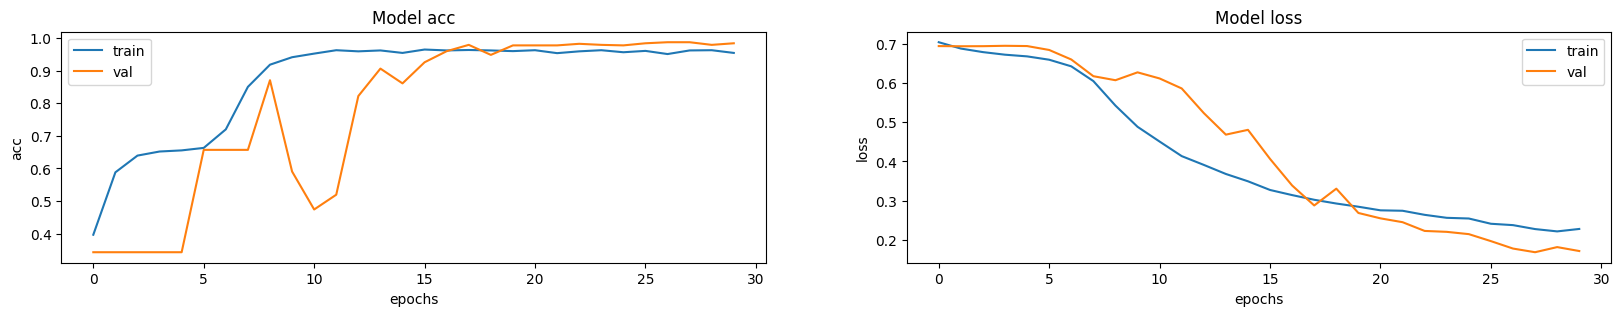

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [15]:
# Load saved model & weights
model = keras.models.load_model('3d_brainLoss_class32_1.h5')
model.load_weights("3d_brainLoss_class32_1.h5")

In [16]:
model.predict(np.expand_dims(X_test[10], axis=0))[0]

1/1 [==============================] - 0s 121ms/step


array([0.8863324], dtype=float32)

In [18]:
Y_test[10]

1